In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import matplotlib.pyplot as plt

In [ ]:
#Setting the random seeds for reproducability
import random
np.random.seed(42)
random.seed(42)

In [ ]:
medical_train_raw = pd.read_csv("/content/drive/MyDrive/Bachelor Scriptie KI/DrugReviews/drugsComTrain_raw.tsv", sep="\t")

In [ ]:
medical_test_raw = pd.read_csv("/content/drive/MyDrive/Bachelor Scriptie KI/DrugReviews/drugsComTest_raw.tsv", sep="\t")

In [ ]:
medical_train_raw.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [ ]:
medical_train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   161297 non-null  int64  
 1   drugName     161297 non-null  object 
 2   condition    160398 non-null  object 
 3   review       161297 non-null  object 
 4   rating       161297 non-null  float64
 5   date         161297 non-null  object 
 6   usefulCount  161297 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 8.6+ MB


In [ ]:
medical_test_raw.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10.0,"February 28, 2012",22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8.0,"May 17, 2009",17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9.0,"September 29, 2017",3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9.0,"March 5, 2017",35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9.0,"October 22, 2015",4


In [ ]:
medical_test_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53766 entries, 0 to 53765
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   53766 non-null  int64  
 1   drugName     53766 non-null  object 
 2   condition    53471 non-null  object 
 3   review       53766 non-null  object 
 4   rating       53766 non-null  float64
 5   date         53766 non-null  object 
 6   usefulCount  53766 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 2.9+ MB


From the info, we can see that all columns are filled with values, except for 'Condition'. Here, there are some NULL-values. Should not be a problem, since we will not be using this column.

# Preprocessing

Some of the ratings are strings, while others are floats. Need to fix this first.

This dataset does not have a column containing the label/sentiment of the sentence. However, we will use rating for this. The sentiments will then be the following:


*   Negative: 1.0 - 4.0
*   Neutral: 5.0 - 6.0
*   Positive: 7.0 - 10.0



In [ ]:
def convert_to_floats(dataframe):
  """
  Given a dataframe, convert all values in the rating-column into floats.

  param dataframe: Pandas DataFrame containing the ratings.
  """
  j = 0
  for i in dataframe.rating:
    dataframe.rating[j] = float(i)
    j += 1

In [ ]:
convert_to_floats(medical_train_raw)
convert_to_floats(medical_test_raw)

<ipython-input-11-c25fd25c12ac>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.rating[j] = float(i)


<Axes: xlabel='rating', ylabel='count'>

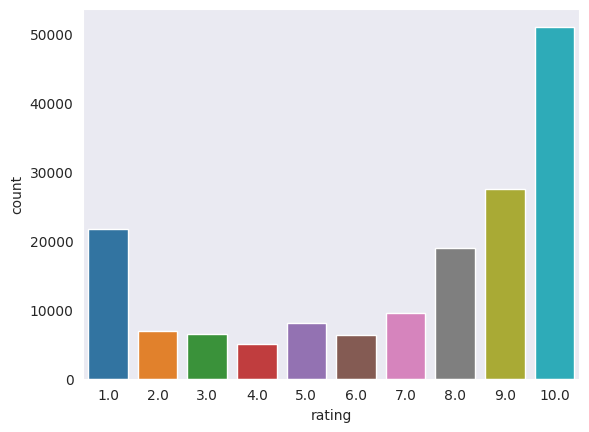

In [ ]:
sns.set_style("dark")
sns.countplot(medical_train_raw, x="rating")

In [ ]:
medical_train_raw.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [ ]:
#Only the review and rating are needed, so we will extract these from the dataframe.

train_reviews = medical_train_raw['review'].tolist()
train_ratings = medical_train_raw['rating'].tolist()
print(type(train_reviews))
test_reviews = medical_test_raw['review'].tolist()
test_ratings = medical_test_raw['rating'].tolist()

<class 'list'>


In [ ]:
train_dict = {"Review": train_reviews, "Rating": train_ratings}
test_dict = {"Review": test_reviews, "Rating": test_ratings}

In [ ]:
medical_train = pd.DataFrame(data=train_dict)
medical_test = pd.DataFrame(data=test_dict)

In [ ]:
medical_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Review  161297 non-null  object 
 1   Rating  161297 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [ ]:
medical_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53766 entries, 0 to 53765
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Review  53766 non-null  object 
 1   Rating  53766 non-null  float64
dtypes: float64(1), object(1)
memory usage: 840.2+ KB


In [ ]:
y = []
for sent in medical_train.Review:
  y.append(len(sent))

Text(0, 0.5, 'Number of sentences')

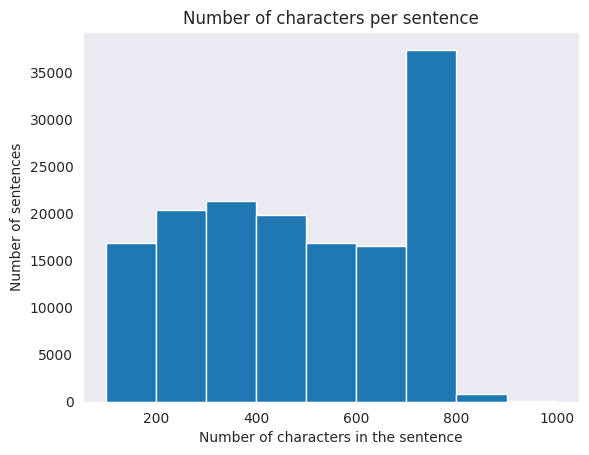

In [ ]:
import matplotlib.pyplot as plt
plt.hist(y, bins=[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
plt.title("Number of characters per sentence")
plt.xlabel("Number of characters in the sentence")
plt.ylabel("Number of sentences")

We can see from the plot above that the number of characters of the reviews are fairly evenly distributed, with a peak around 800 characters. The sentences of this dataset are therefore longer than those of the Financial Phrasebank.

# Clean and tokenize

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
import string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def remove_punctuation(tokenized_sent):
  """
  Function that removes certain unwanted characters from a tokenized sentence, specified in the set 'punctuation'
  Returns the cleaned-up tokenized sentence.

  param tokenized_sent: list of tokens, still containing punctuation.
  """
  punctuation = {'!', '#', '&', '(', ')', ',', ':', ';', '?', '[', ']', '@', '.', '"', '``'}
  new = []
  i = 0
  for token in tokenized_sent:
    if (not token in punctuation) and i > 0 and i < len(tokenized_sent) - 1:
      new.append(token)
    i += 1
  return new

In [ ]:
def tokenize_and_clean(dataframe):
  """
  Given a dataframe with sentences, tokenize and clean them.

  param dataframe: Pandas DataFrame containing sentences.
  """
  i = 0
  for sentence in dataframe.Review:
    tokenized = word_tokenize(sentence)
    clean = remove_punctuation(tokenized)
    dataframe.Review[i] = clean
    i += 1

In [ ]:
#Tokenize and clean the sentences in medical_train. The function doesn't return anything, but edits the existing dataframe.
#This takes quite a long time due to the large amount of sentences.
print(medical_train.head())
tokenize_and_clean(medical_train)
print(medical_train.head())

<ipython-input-25-1030ceaa7b03>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.Review[i] = clean


                                              Review  Rating
0  "It has no side effect, I take it in combinati...     9.0
1  "My son is halfway through his fourth week of ...     8.0
2  "I used to take another oral contraceptive, wh...     5.0
3  "This is my first time using any form of birth...     8.0
4  "Suboxone has completely turned my life around...     9.0
                                              Review  Rating
0  [It, has, no, side, effect, I, take, it, in, c...     9.0
1  [My, son, is, halfway, through, his, fourth, w...     8.0
2  [I, used, to, take, another, oral, contracepti...     5.0
3  [This, is, my, first, time, using, any, form, ...     8.0
4  [Suboxone, has, completely, turned, my, life, ...     9.0


In [ ]:
print(medical_test.head())
tokenize_and_clean(medical_test)
print(medical_test.head())

                                              Review  Rating
0  "I&#039;ve tried a few antidepressants over th...    10.0
1  "My son has Crohn&#039;s disease and has done ...     8.0
2                      "Quick reduction of symptoms"     9.0
3  "Contrave combines drugs that were used for al...     9.0
4  "I have been on this birth control for one cyc...     9.0


<ipython-input-25-1030ceaa7b03>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.Review[i] = clean


                                              Review  Rating
0  [I, 039, ve, tried, a, few, antidepressants, o...    10.0
1  [My, son, has, Crohn, 039, s, disease, and, ha...     8.0
2                   [Quick, reduction, of, symptoms]     9.0
3  [Contrave, combines, drugs, that, were, used, ...     9.0
4  [I, have, been, on, this, birth, control, for,...     9.0


In [ ]:
def wordcount(dataframe):
  """
  Counts the lengths of the sentences in the dataframe.

  param dataframe: Pandas DataFrame containing the sentences.
  """
  wordcounter = []
  for sentence in dataframe.Review:
    counter = 0
    for word in sentence:
      counter += 1
    wordcounter.append(counter)
  return wordcounter

In [ ]:
word_amounts = wordcount(medical_train)

Text(0, 0.5, 'Number of sentences')

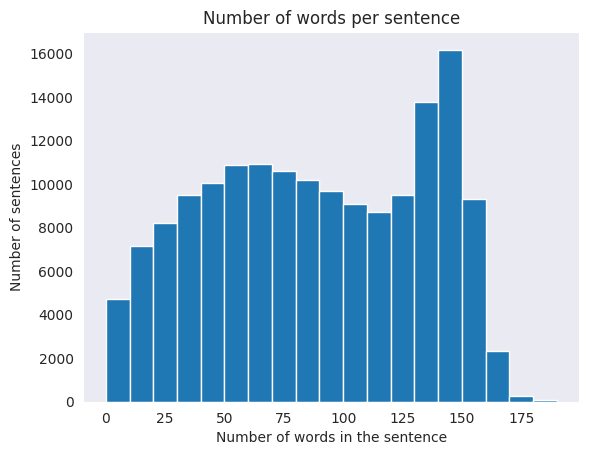

In [ ]:
plt.hist(word_amounts, bins=bins)
plt.title("Number of words per sentence")
plt.xlabel("Number of words in the sentence")
plt.ylabel("Number of sentences")

The number of words per sentence is plotted above. We have another peak around 150 words, with a fairly even distribution around 75 words.

In [ ]:
def convert_to_lower(dataframe):
  """
  Converts all sentences in a dataframe to lowercase.

  param dataframe: Pandas DataFrame containing the sentences.
  """
  i = 0
  for row in dataframe.Review:
    lowered = [w.lower() for w in row]
    dataframe.Review[i] = lowered
    i += 1

In [ ]:
print(medical_train.head())
convert_to_lower(medical_train)
print(medical_train.head())

                                              Review  Rating
0  [It, has, no, side, effect, I, take, it, in, c...     9.0
1  [My, son, is, halfway, through, his, fourth, w...     8.0
2  [I, used, to, take, another, oral, contracepti...     5.0
3  [This, is, my, first, time, using, any, form, ...     8.0
4  [Suboxone, has, completely, turned, my, life, ...     9.0


<ipython-input-34-852a2ca681b5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.Review[i] = lowered


                                              Review  Rating
0  [it, has, no, side, effect, i, take, it, in, c...     9.0
1  [my, son, is, halfway, through, his, fourth, w...     8.0
2  [i, used, to, take, another, oral, contracepti...     5.0
3  [this, is, my, first, time, using, any, form, ...     8.0
4  [suboxone, has, completely, turned, my, life, ...     9.0


In [ ]:
print(medical_test.head())
convert_to_lower(medical_test)
print(medical_test.head())

                                              Review  Rating
0  [I, 039, ve, tried, a, few, antidepressants, o...    10.0
1  [My, son, has, Crohn, 039, s, disease, and, ha...     8.0
2                   [Quick, reduction, of, symptoms]     9.0
3  [Contrave, combines, drugs, that, were, used, ...     9.0
4  [I, have, been, on, this, birth, control, for,...     9.0


<ipython-input-34-852a2ca681b5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.Review[i] = lowered


                                              Review  Rating
0  [i, 039, ve, tried, a, few, antidepressants, o...    10.0
1  [my, son, has, crohn, 039, s, disease, and, ha...     8.0
2                   [quick, reduction, of, symptoms]     9.0
3  [contrave, combines, drugs, that, were, used, ...     9.0
4  [i, have, been, on, this, birth, control, for,...     9.0


In [ ]:
#Remove the 039 tokens, which were a part of the encoding for the '
j = 0
for sent in medical_train.Review:
  i = 0
  for word in sent:
    if word =="039":
      medical_train.Review[j][i] = "\'"
    i += 1
  j += 1

In [ ]:
print(medical_train.head())

                                              Review  Rating
0  [it, has, no, side, effect, i, take, it, in, c...     9.0
1  [my, son, is, halfway, through, his, fourth, w...     8.0
2  [i, used, to, take, another, oral, contracepti...     5.0
3  [this, is, my, first, time, using, any, form, ...     8.0
4  [suboxone, has, completely, turned, my, life, ...     9.0


In [ ]:
j = 0
for sent in medical_test.Review:
  i = 0
  for word in sent:
    if word =="039":
      medical_test.Review[j][i] = "\'"
    i += 1
  j += 1

In [ ]:
print(medical_test.head())

                                              Review  Rating
0  [i, ', ve, tried, a, few, antidepressants, ove...    10.0
1  [my, son, has, crohn, ', s, disease, and, has,...     8.0
2                   [quick, reduction, of, symptoms]     9.0
3  [contrave, combines, drugs, that, were, used, ...     9.0
4  [i, have, been, on, this, birth, control, for,...     9.0


In [ ]:
#Analyze the most occuring stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import defaultdict

def get_stopword_counts(dataframe):
  """
  Given a dataframe with tokenized sentences, count the stopwords.

  param dataframe: Pandas DataFrame containing the sentences.
  """
  counter = defaultdict(int)
  for sent in dataframe.Review:
    for token in sent:
      if token in stopwords.words('english'):
        counter[token] += 1
  return counter


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
stopword_counts = get_stopword_counts(medical_train)

In [ ]:
top=sorted(stopword_counts.items(), key=lambda x:x[1],reverse=True)[:10]
x,y=zip(*top)
plt.bar(x,y)
plt.title("The most occuring stopwords in Drugs.com Reviews")
plt.xlabel("The most occuring stopwords")
plt.ylabel("The amount of occurences")

The most occuring stopword in the dataset is the word 'I'. This is fairly logical, since most people write about their experiences with the drug.The other stopwords are not that special, but they do occur less than half as much as 'I'.

In [ ]:
def make_BOW(dataframe):
  """
  Given sentences in the dataframe, create a list containing all words occuring in the dataset.

  param dataframe: Pandas DataFrame containing the sentences.
  """
  bag = []
  for sent in dataframe.Review:
    for word in sent:
      bag.append(word)
  return bag


def count_unique_words(BOW):
  """
  Given a list of words, count how many time each word occurs.

  param BOW: list of words occuring in the dataset.
  """
  counts = {}
  for word in BOW:
    if word in counts:
      counts[word] += 1
    else:
      counts[word] = 1

  unique = 0
  for item in counts:
    unique += 1
  return unique

In [ ]:
medical_BOW = make_BOW(medical_train)
medical_BOW

In [ ]:
count_unique_words(medical_BOW)

So the dataset contains 73,952 unique words.

# Stopwords

In [ ]:
def remove_stopwords(dataframe):
  """
  Given a dataframe with tokenized sentences, remove the stopwords.

  param dataframe: Pandas DataFrame containing tokenized sentences with stopwords.
  """
  j = 0
  for row in dataframe.Review:
    temp = []
    for w in row:
      if w not in stopwords.words('english'):
        temp.append(w)
    dataframe.Review[j] = temp
    j += 1

In [ ]:
print(medical_train.head())
remove_stopwords(medical_train)
print(medical_train.head())

                                              Review  Rating
0  [it, has, no, side, effect, i, take, it, in, c...     9.0
1  [my, son, is, halfway, through, his, fourth, w...     8.0
2  [i, used, to, take, another, oral, contracepti...     5.0
3  [this, is, my, first, time, using, any, form, ...     8.0
4  [suboxone, has, completely, turned, my, life, ...     9.0


<ipython-input-42-3904f8710eb1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.Review[j] = temp


                                              Review  Rating
0  [side, effect, take, combination, bystolic, 5,...     9.0
1  [son, halfway, fourth, week, intuniv, became, ...     8.0
2  [used, take, another, oral, contraceptive, 21,...     5.0
3  [first, time, using, form, birth, control, ', ...     8.0
4  [suboxone, completely, turned, life, around, f...     9.0


In [ ]:
print(medical_test.head())
remove_stopwords(medical_test)
print(medical_test.head())

                                              Review  Rating
0  [i, ', ve, tried, a, few, antidepressants, ove...    10.0
1  [my, son, has, crohn, ', s, disease, and, has,...     8.0
2                   [quick, reduction, of, symptoms]     9.0
3  [contrave, combines, drugs, that, were, used, ...     9.0
4  [i, have, been, on, this, birth, control, for,...     9.0


<ipython-input-42-3904f8710eb1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.Review[j] = temp


                                              Review  Rating
0  [', tried, antidepressants, years, citalopram,...    10.0
1  [son, crohn, ', disease, done, well, asacol, c...     8.0
2                       [quick, reduction, symptoms]     9.0
3  [contrave, combines, drugs, used, alcohol, smo...     9.0
4  [birth, control, one, cycle, reading, reviews,...     9.0


In [ ]:
def convert_labels(dataframe):
  """
  Given a dataframe with ratings, convert these ratings into sentiment labels.
  1-4: negative;
  5-6: neutral;
  7-10: positive.

  param dataframe: Pandas DataFrame containing the sentences.
  """
  i = 0
  for label in dataframe.Rating:
    if label < 5:
      dataframe.Rating[i] = 0
    elif (label == 5) or (label == 6):
      dataframe.Rating[i] = 1
    else:
      dataframe.Rating[i] = 2
    i += 1


In [ ]:
print(medical_train.head())
convert_labels(medical_train)
print(medical_train.head())

                                              Review  Rating
0  [side, effect, take, combination, bystolic, 5,...     9.0
1  [son, halfway, fourth, week, intuniv, became, ...     8.0
2  [used, take, another, oral, contraceptive, 21,...     5.0
3  [first, time, using, form, birth, control, ', ...     8.0
4  [suboxone, completely, turned, life, around, f...     9.0


<ipython-input-46-bcd7ba9ef44c>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.Rating[i] = 2
<ipython-input-46-bcd7ba9ef44c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.Rating[i] = 1
<ipython-input-46-bcd7ba9ef44c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.Rating[i] = 0


                                              Review  Rating
0  [side, effect, take, combination, bystolic, 5,...     2.0
1  [son, halfway, fourth, week, intuniv, became, ...     2.0
2  [used, take, another, oral, contraceptive, 21,...     1.0
3  [first, time, using, form, birth, control, ', ...     2.0
4  [suboxone, completely, turned, life, around, f...     2.0


In [ ]:
print(medical_test.head())
convert_labels(medical_test)
print(medical_test.head())

                                              Review  Rating
0  [', tried, antidepressants, years, citalopram,...    10.0
1  [son, crohn, ', disease, done, well, asacol, c...     8.0
2                       [quick, reduction, symptoms]     9.0
3  [contrave, combines, drugs, used, alcohol, smo...     9.0
4  [birth, control, one, cycle, reading, reviews,...     9.0


<ipython-input-46-bcd7ba9ef44c>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.Rating[i] = 2
<ipython-input-46-bcd7ba9ef44c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.Rating[i] = 0
<ipython-input-46-bcd7ba9ef44c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.Rating[i] = 1


                                              Review  Rating
0  [', tried, antidepressants, years, citalopram,...     2.0
1  [son, crohn, ', disease, done, well, asacol, c...     2.0
2                       [quick, reduction, symptoms]     2.0
3  [contrave, combines, drugs, used, alcohol, smo...     2.0
4  [birth, control, one, cycle, reading, reviews,...     2.0


In [ ]:
#Again, we join all tokenized sentences for the VADER lexicon.
train_sentences = []

for sent in medical_train.Review:
  joined = ' '.join(sent)
  train_sentences.append(joined)

In [ ]:
train_sentiments = []

for sentiment in medical_train.Rating:
  train_sentiments.append(sentiment)

In [ ]:
test_sentences = []

for sent in medical_test.Review:
  joined = ' '.join(sent)
  test_sentences.append(joined)

In [ ]:
test_sentiments = []

for sentiment in medical_test.Rating:
  test_sentiments.append(sentiment)

In [ ]:
train_dict = {'Sentence': train_sentences, 'Sentiment': train_sentiments}
test_dict = {'Sentence': test_sentences, 'Sentiment': test_sentiments}

In [ ]:
train_set = pd.DataFrame(data=train_dict)
test_set = pd.DataFrame(data=test_dict)

In [ ]:
train_set

,Sentence,Sentiment
0,side effect take combination bystolic 5 mg fis...,2.0
1,son halfway fourth week intuniv became concern...,2.0
2,used take another oral contraceptive 21 pill c...,1.0
3,first time using form birth control ' glad wen...,2.0
4,suboxone completely turned life around feel he...,2.0
...,...,...
161292,wrote first report mid-october 2014 alcohol si...,2.0
161293,given iv surgey immediately became anxious cou...,0.0
161294,limited improvement 4 months developed bad ras...,0.0
161295,' thyroid medication 49 years spent first 38 s...,2.0


In [ ]:
test_set

,Sentence,Sentiment
0,' tried antidepressants years citalopram fluox...,2.0
1,son crohn ' disease done well asacol complaint...,2.0
2,quick reduction symptoms,2.0
3,contrave combines drugs used alcohol smoking o...,2.0
4,birth control one cycle reading reviews type s...,2.0
...,...,...
53761,taken tamoxifen 5 years side effects severe sw...,2.0
53762,' taking lexapro escitaploprgram since februar...,2.0
53763,' married 34 years old kids taking pill hassle...,2.0
53764,prescribed nucynta severe neck/shoulder pain t...,0.0


# We can now save the prepared train and test sets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

train_path = '/content/drive/My Drive/Bachelor Scriptie KI/DrugReviews/clean_train_drugscom.csv'
test_path = '/content/drive/My Drive/Bachelor Scriptie KI/DrugReviews/clean_test_drugscom.csv'
with open(train_path, 'w', encoding = 'utf-8-sig') as f:
  train_set.to_csv(f)

with open(test_path, 'w', encoding = 'utf-8-sig') as f:
  test_set.to_csv(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Some further analysis

In [ ]:
def get_non_stopword_counts(dataframe):
  """
  Given a dataframe with tokenized sentences, count how many non-stopwords occur.

  param dataframe: Pandas DataFrame containing the sentences.
  """
  counter = defaultdict(int)
  for sent in dataframe.Review:
    for token in sent:
      if token not in stopwords.words('english'):
        counter[token] += 1
  return counter

In [ ]:
non_stopword_counts = get_non_stopword_counts(medical_train)

Text(0, 0.5, 'The amount of occurences')

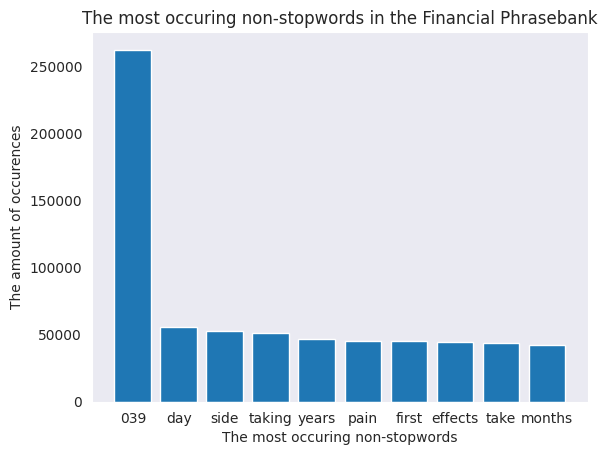

In [ ]:
top=sorted(non_stopword_counts.items(), key=lambda x:x[1],reverse=True)[:10]
x,y=zip(*top)
plt.bar(x,y)
plt.title("The most occuring non-stopwords in the Financial Phrasebank")
plt.xlabel("The most occuring non-stopwords")
plt.ylabel("The amount of occurences")

The most occuring word in the dataset that is not a stopword is '039', and it occurs disproportionally more than the other most occuring words. This is originating from &#039, which is the HTML encoding of the ' character. From a quick scan of the dataset, it seems that this occurs an insane amount of times (250,000 apparently).

### As was found during the analysis for the financial dataset, lemmatization and stemming gave suboptimal results that led to quite a large loss of information. Hence, we also do not apply it for this dataset.

# N-grams and Wordcloud

## N-grams

In [ ]:
#The corpus just is a big list containing all words occuring in the dataset (these include doubles)
corpus = []
corpus=[word for sent in medical_train.Review for word in sent]

In [ ]:
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
def get_top_ngram(corpus, n=2):
  """
  Given a corpus of words, extract the most occuring n-grams.

  param corpus: (list) containing all words in the dataset.
  param n: (int) the lenght of n-grams we want (2 means bigrams).
  """
  vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis=0)
  words_freq = [(word, sum_words[0, idx])
                for word, idx in vec.vocabulary_.items()]
  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
  return words_freq[:10]

In [ ]:
top_bigrams = get_top_ngram(corpus)

In [ ]:
print(top_bigrams)

[('side effects', 692), ('tri cyclen', 427), ('tri sprintec', 427), ('anti depressants', 377), ('anti depressant', 334), ('non stop', 314), ('and or', 291), ('10 325', 291), ('mg day', 288), ('co pay', 282)]


<Axes: >

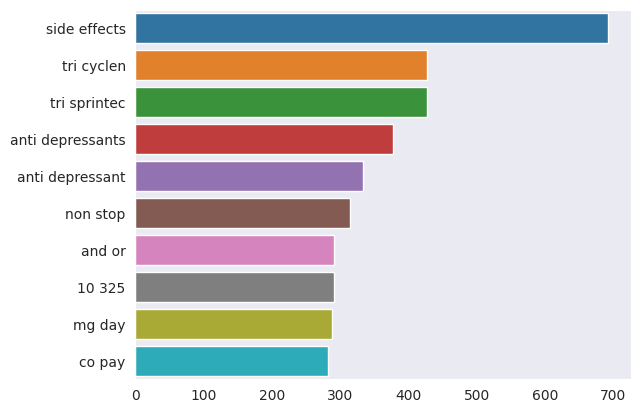

In [ ]:
x,y=map(list,zip(*top_bigrams))
sns.barplot(x=y,y=x)

The bigrams above seem like bigrams that would naturally occur in medical texts. Especially the most popular bigram is something that we would expect to be mentioned a lot, since people often want to know whether certain drugs have side effects. Also anti-depressant(s), mg day and non stop seem logical for medical reviews.

In [ ]:
top_trigrams = get_top_ngram(corpus, n=3)

<Axes: >

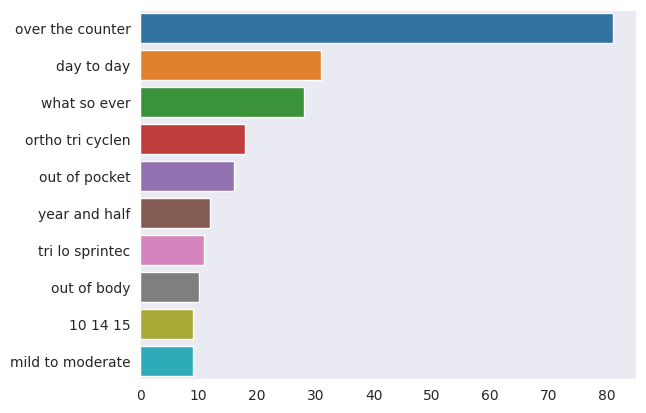

In [ ]:
x,y=map(list,zip(*top_trigrams))
sns.barplot(x=y,y=x)

Again, these trigrams are what we would expect.

## Wordcloud

In [ ]:
from wordcloud import WordCloud

In [ ]:
stopwords = stopwords.words('english')

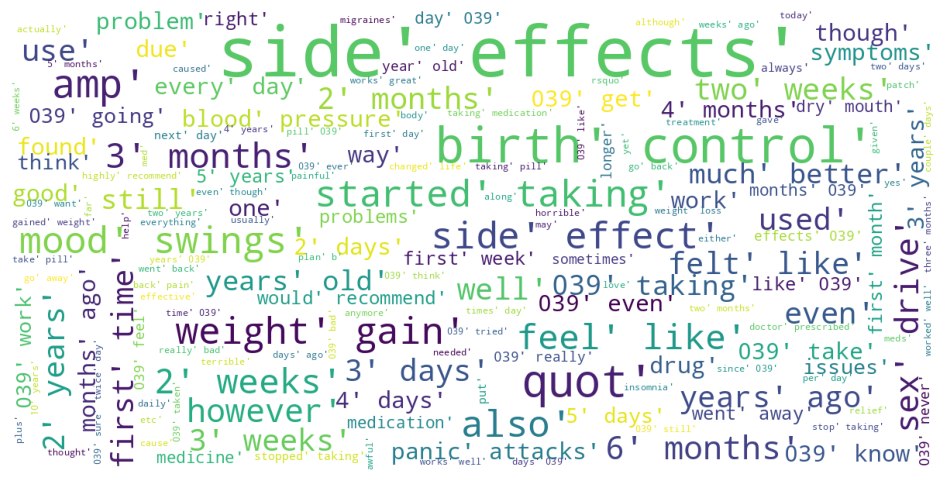

In [ ]:
def show_wordcloud(corpus):
  """
  Given the corpus, generate and plot the Wordcloud.

  param corpus: (list) containing all words in the dataset.
  """
  #Specify the type of WordCloud.
  wordcloud = WordCloud(
      background_color='white',
      stopwords=stopwords,
      max_words=200,
      max_font_size=30,
      scale=3,
      random_state=42)

  #Generate the WordCloud.
  wordcloud=wordcloud.generate(str(corpus))

  #Plot the WordCloud.
  fig = plt.figure(1, figsize=(12, 12))
  plt.axis('off')

  plt.imshow(wordcloud)
  plt.show()

show_wordcloud(corpus)

The wordcloud shows us the most mentioned bigram 'side effects', this time as separate words. Other notable mentions are birth, control, weight, gain, weeks, symptoms, problem. These are all words we would expect to occur often in medical drug reviews.